# Tutorial 3. Use SEDR to do batch integration.

Here we use 3 sections from DLPFC data to show the ability of SEDR to integrate batches for the same tissue with the same techniques. 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import multiprocessing as mp
from GraphST import GraphST
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
data_root = Path('../data/BaristaSeq/')

proj_list = [
    'Slice_1_removed.h5ad', 'Slice_2_removed.h5ad', 'Slice_3_removed.h5ad'
]

# '151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675','151676'

In [3]:
# adata = sc.read('../data/BaristaSeq/Slice_1_removed.h5ad')

In [4]:
# adata

## Combining datasets

Input of SEDR includes an AnnData object that contains the spatial transcriptomics data and a graph dictionary that contains the neighborhood graph. When combining two datasets, the AnnData objects are directly concatenated. For neighborhood graphs, we follow the following algorithm.  
Let $A^k$ and $Z_f^k$ denote the adjacency matrix and deep gene representation of spatial omics k, we then create a block-diagonal adjacency matrix $A^k$  and concatenate the deep gene representation in the spot dimension, as:  
![](batch_integration.png)  
where K is the number of spatial omics. 


In [5]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read(data_root / proj_name)
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    
    ##### Load layer_guess label, if have
    # df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
    # adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    # adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        name = name + '_' + proj_name
    print(adata.X.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.46it/s]

(1525, 79)
(3567, 79)
(5257, 79)


## Preprocessing

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 73.37it/s]

Optimization finished for ST data!


## use harmony to calculate revised PCs

In [7]:
import harmonypy as hm

meta_data = adata.obs[['batch']]

data_mat = adata.obsm['emb']
vars_use = ['batch']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df

2025-04-07 21:34:22,161 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-07 21:34:25,866 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-07 21:34:25,895 - harmonypy - INFO - Iteration 1 of 10
2025-04-07 21:34:27,024 - harmonypy - INFO - Iteration 2 of 10
2025-04-07 21:34:27,834 - harmonypy - INFO - Converged after 2 iterations


## Visualizing

### UMAP

In [8]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata, min_dist=0.2)

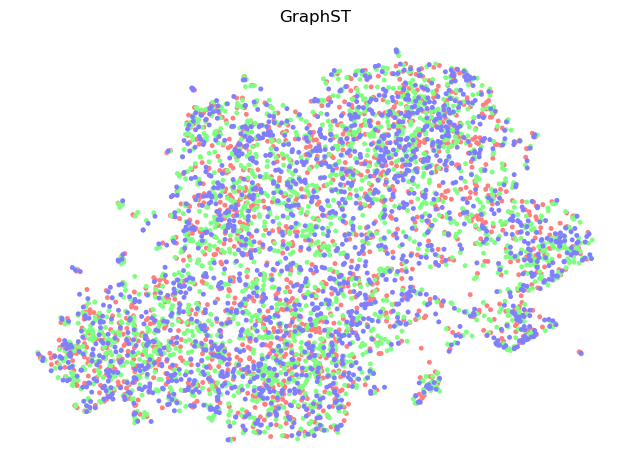

In [9]:
sc.pl.umap(
    adata, 
    color=['batch_name'], 
    palette=['#FF7F7F', '#7FFF7F', '#7F7FFF'], 
    show=False, 
    size=50, 
    frameon=False,  # 去掉外边框
    legend_loc='left margin',  # 调整图例位置
    title="GraphST" 
)

# 获取当前图形并修改散点样式
ax = plt.gca()
for path in ax.spines.values():  
    path.set_visible(True)  # 显示边框
    path.set_linewidth(0)   # 设置边框粗细

# 手动调整点的边框颜色
scatter = ax.collections[0]  # 获取散点图
scatter.set_edgecolor('white')  # 设置边框颜色
scatter.set_linewidth(0)  # 设置边框宽度
plt.tight_layout()
plt.savefig('umap_batch.svg', format='svg')
plt.show()

### LISI score

In [10]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch']], label_colnames=['batch'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['Region']], label_colnames=['Region'])[:, 0]

In [11]:
mean_ILISI = np.mean(np.array(ILISI))
mean_CLISI = np.mean(np.array(CLISI))
print("mean_ILISI:", mean_ILISI)
print("mean_CLISI:", mean_CLISI)

mean_ILISI: 1.7315438325768444
mean_CLISI: 1.7385493565611039


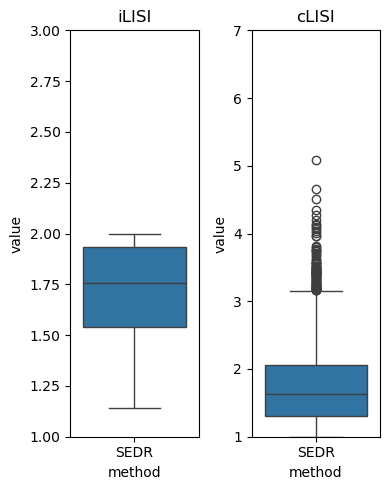

In [12]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI']*len(CLISI)
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()